# Pairing HamiltonianのQPE計算 (Pennylane)

この章では、pennylaneを使って、long-term algorithmである量子位相推定(QPE)の実装を行う。
まずは、ancilla qubitが1つの場合としてHadamard testを実装し、その後、QPEへと拡張する。

In [1]:
import numpy as o_np #pennylaneのnumpyと被らないように
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import pennylane as qml 
from pennylane import numpy as np
from pennylane.templates import QuantumPhaseEstimation

Hamiltonianを再掲しておこう:

$$
\begin{align}
P^{\dagger}_p & = \frac{1}{2} (X_p - iY_p) \\
P_p & = \frac{1}{2} (X_p + iY_p) \\
N_p & = \frac{1}{2} ( 1  - Z_p) \\
H & = \sum_{p} \epsilon_p N_p - g \sum_{pq} P^{\dagger}_p P_q \\
& = \sum_{p} \epsilon_p \frac{1}{2} ( 1  - Z_p) - g \sum_{pq} \frac{1}{4} (X_p - iY_p)(X_q + iY_q) \\
& = \sum_{p} \frac{\epsilon_p - g}{2} (1 - Z_p ) - \frac{g}{4} \sum_{p \neq q} (X_pX_q + Y_pY_q) \\
\end{align}
$$

以下では、$N_\mathrm{orb}=4, N_\mathrm{occ}=2, g = 0.33$にとって考えることにする。
ansatz(状態作成)部分は$N_\mathrm{orb}=4, N_\mathrm{occ}=2$を、
角度パラメータは$g=0.33$のもとでの厳密解を与える値をそれぞれ仮定した実装である点を断っておく。

In [2]:
Norb = 4
Nocc = 2
gval = 0.33

In [3]:
class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = o_np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

def ij_tuple_to_AdagA_str(tuple_in):
    i, j = tuple_in
    return f"{i}^ {j}"


Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals, evecs = o_np.linalg.eigh(Hamil.Hmat)
evals = o_np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]
E_HF = Hamil.Hmat[0,0]

print("basis:", Hamil.basis)
print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
print("eps: ", Hamil.epsilon)
print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
print("Egs_exact: ", Egs_exact, " E_HF", E_HF)
print("gs evec", evecs[:,0])

# Qubit Hamiltonian
SPEs = Hamil.epsilon
obs = [ ]
coeffs = [ ]

# 1-Zp term
for i in range(Hamil.Norb):
    op = qml.Identity(i) - qml.PauliZ(i)
    obs += [ op ]
    coeffs += [ 0.5 * (SPEs[i] - Hamil.gval) ]
# XX+YY term
for i in range(Hamil.Norb):
    for j in range(Hamil.Norb):
        if i == j:
            continue
        factor = - Hamil.gval / 4
        XX = qml.PauliX(i) @ qml.PauliX(j); obs += [ XX ]; coeffs+= [ factor ]
        YY = qml.PauliY(i) @ qml.PauliY(j); obs += [ YY ]; coeffs+= [ factor ]
H_qubit = qml.Hamiltonian(coeffs, obs)
print("H_qubit: ", H_qubit)

params_exact = 2 * np.array(
    [-0.24052408031489098, -0.5198881673506184, -0.49481759937881004, -0.5924147175751697, -0.27420571516474473]
) 

basis: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
['|1100>', '|1010>', '|1001>', '|0110>', '|0101>', '|0011>']
eps:  [0.0, 2.0, 4.0, 6.0]
Hmat:  [[ 1.34 -0.33 -0.33 -0.33 -0.33  0.  ]
 [-0.33  3.34 -0.33 -0.33  0.   -0.33]
 [-0.33 -0.33  5.34  0.   -0.33 -0.33]
 [-0.33 -0.33  0.    5.34 -0.33 -0.33]
 [-0.33  0.   -0.33 -0.33  7.34 -0.33]
 [ 0.   -0.33 -0.33 -0.33 -0.33  9.34]]
evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]
Egs_exact:  1.1898518351360725  E_HF 1.3399999999999999
gs evec [0.97121327 0.18194077 0.09817385 0.09817385 0.06360816 0.01789242]
H_qubit:  -0.165 * (I(0) + -1 * Z(0)) + 0.835 * (I(1) + -1 * Z(1)) + 1.835 * (I(2) + -1 * Z(2)) + 2.835 * (I(3) + -1 * Z(3)) + -0.0825 * (X(0) @ X(1)) + -0.0825 * (Y(0) @ Y(1)) + -0.0825 * (X(0) @ X(2)) + -0.0825 * (Y(0) @ Y(2)) + -0.0825 * (X(0) @ X(3)) + -0.0825 * (Y(0) @ Y(3)) + -0.0825 * (X(1) @ X(0)) + -0.0825 * (Y(1) @ Y(0)) + -0.0825 * (X(1) @ X(2)) + -0.0825 * (Y(1) @ Y(2)) + -0.0825 * (X(1) @ X

## 時間発展演算子: $U=\exp{(-i\hat{H}t)}$

上のHamiltonianを少し整理して、１,2-body termで整理する:

$$
\begin{align}
\hat{H} &= 
\sum_{p} \frac{\epsilon_p - g}{2} (I_p - Z_p ) - \frac{g}{2} \sum_{p > q} (X_pX_q + Y_pY_q)
\equiv H_\epsilon + H_g
\end{align}
$$

また、以下ではPythonでの実装を想定して$N$量子ビット系を$0$ ~ $N-1$でラベルすることにする。

すると、first-orderのTrotter-Suzuki分解{eq}`SuzukiTrotter_1`は以下のようにかける:

$$
\begin{align}
e^{-i \hat{H} t} & = 
\left(
e^{-iH_\epsilon t /r }
\prod^{N-1}_{p>q=0}
e^{\frac{igt}{2r} (X_pX_q+Y_pY_q)}
\right)^r
+\mathcal{O}\left( \left( \frac{N(N-1)}{2}+1 \right) t^2/r \right)
\end{align}
$$

:::{admonition}  Trotter-Suzuki approximation
:class: tip
$H=\sum^m_{i=1} h_i$と非可換な項に分解できるとき、trotter-step $r$に対して、以下のように近似できる:

First-order:  

$$
\begin{align}
e^{iHt} & = \left( e^{-i h_j t /r} \right)^r + \mathcal{O}(m^2t^2/r)
\end{align}
$$ (SuzukiTrotter_1)

Second-order:

$$
\begin{align}
e^{iHt} & = \left( e^{-i h_j t /2r}  \prod^1_{j=m} e^{-ih_jt/2r} \right)^r + \mathcal{O}(m^3t^3/r^2)
\end{align}
$$ (SuzukiTrotter_2)

:::


また、一体項部分はPhase shift gateを用いて以下のようにまとめてかける:

$$
\begin{align}
e^{-iH_\epsilon t } & 
= \bigotimes^{N-1}_{p=0} 
\begin{pmatrix}
1 & 0 \\
0 & \exp(-i\epsilon_p t)
\end{pmatrix}
= \bigotimes^{N-1}_{p=0} P(-\epsilon_p t)
\end{align}
$$

pennylenでは、Trotter分解を行うには、`TrotterProduct`メソッドを用いて演算子とステップ数, 時間$t$, 次数(order)を指定してやれば良い。

## Hadamard test



In [246]:
n_ancilla = 1
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_HadamardTest(H_qubit):
    q_ancilla = Norb
    # State preparation
    if method_state == "HF":
        qml.PauliX(0)
        qml.PauliX(1)
    if method_state == "ansatz":
        qml.PauliX(0)
        qml.PauliX(1)
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Time Evolution
    iHt = qml.TrotterProduct(H_qubit, n=trotter_step, time=time_step, order=1)

    # Hadamard test
    qml.Hadamard(wires=q_ancilla)
    qml.ControlledQubitUnitary(iHt, control_wires=[q_ancilla], wires=range(0, Norb))
    qml.Hadamard(wires=q_ancilla)
    return qml.expval(qml.PauliZ(q_ancilla))


trotter_step = 10
time_step = 2.e-3
method_state = "ansatz"
method_state = "HF"

res = circuit_HadamardTest(H_qubit).item()
p0, p1 = (1 + res) / 2, (1 - res) / 2
Et = np.arccos(res)
E = Et / time_step
print("initial state", method_state, "trotter_step %3d" % trotter_step,
    "time_step %3.1e" % time_step, "E %12.9f" % E, "error %3.1e" % np.abs(E - Egs_exact))

initial state HF trotter_step  10 time_step 2.0e-03 E  1.493718325 error 3.0e-01


厳密解から$\exp(-iEt)$を計算するなどして検算してみよう。

In [5]:
# exp(-iEt)
Uex = np.real(np.exp(-1j * Egs_exact * time_step))

p0_exact = (1 + Uex)/2
p1_exact = (1 - Uex)/2

print("Uex", Uex, "p0_exact", p0_exact, "p1_exact", p1_exact)
print("Et", Egs_exact * time_step , "cos(Et)", np.cos(Egs_exact * time_step))
print("Egs_exact", Egs_exact, "E", E, "Diff.", E - Egs_exact)

Uex 0.9999999929212631 p0_exact 0.9999999964606315 p1_exact 3.539368464977599e-09
Et 0.00011898518351360725 cos(Et) 0.9999999929212631
Egs_exact 1.1898518351360725 E 1.1898516757081505 Diff. -1.5942792197520816e-07


初期状態やtrotter step, time stepなどを変えて試してみよう:

In [248]:
results = []
for method_state in ["HF", "ansatz"]:
    for trotter_step in [1, 10, 100]:
        for p_time_step in range(0, 5):
            time_step = 10**(-p_time_step) 
            res = circuit_HadamardTest(H_qubit).item()
            p0, p1 = (1 + res) / 2, (1 - res) / 2
            Et = np.arccos(res)
            E = Et / time_step
            print("initial state %6s" % method_state, 
                  "trotter_step %3d" % trotter_step,
                  "time_step %3.1e" % time_step, "E %12.9f" % E, "error %3.1e" % np.abs(E - Egs_exact))
            results.append([method_state, trotter_step, np.log10(time_step), E, np.log10(np.abs(E - Egs_exact))])

/Users/sym4p/my_python3_env_forQC/lib/python3.13/site-packages/pennylane/ops/op_math/controlled_ops.py:163: UserWarning: base operator already has wires; values specified through wires kwarg will be ignored.
  warnings.warn(


initial state     HF trotter_step   1 time_step 1.2e+00 E  1.368558476 error 1.8e-01
initial state     HF trotter_step   1 time_step 1.2e-01 E  1.492766438 error 3.0e-01
initial state     HF trotter_step   1 time_step 1.2e-02 E  1.493710674 error 3.0e-01
initial state     HF trotter_step   1 time_step 1.2e-03 E  1.493720094 error 3.0e-01
initial state     HF trotter_step   1 time_step 1.2e-04 E  1.493720296 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.2e+00 E  1.209617754 error 2.0e-02
initial state     HF trotter_step  10 time_step 1.2e-01 E  1.486706331 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.2e-02 E  1.493649255 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.2e-03 E  1.493719483 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.2e-04 E  1.493720974 error 3.0e-01
initial state     HF trotter_step 100 time_step 1.2e+00 E  1.207398092 error 1.8e-02
initial state     HF trotter_step 100 time_step 1.2e-01 E  1.4866

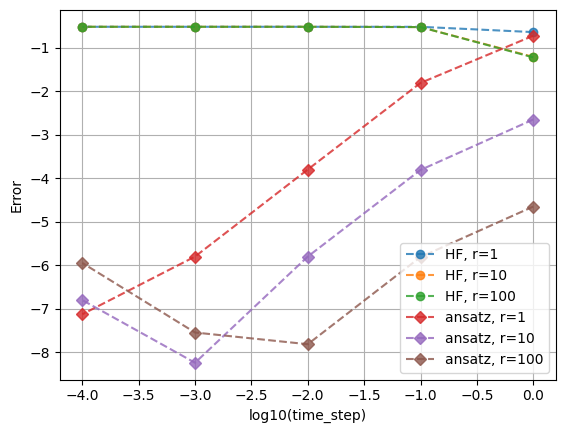

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
results = o_np.array(results)
for method_state in ["HF", "ansatz"]:
    tm = "o" if method_state == "HF" else "D"
    for trotter_step in [1, 10, 100]:
        mask = (results[:,0] == method_state) & (results[:,1] == str(trotter_step) )
        x = list(map(float, results[mask, 2]))
        y = list(map(float, results[mask, 4]))
        ax.plot(x, y, marker=tm, ls="dashed", label=f"{method_state}, r={trotter_step}", alpha=0.8)
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("log10(time_step)")
ax.set_ylabel("Error")
ax.legend()
ax.grid()
plt.show()

## QPE

pennylaneの[Intro to Quantum Phase Estimation](https://pennylane.ai/qml/demos/tutorial_qpe)も参考にしてみよう。

In [232]:
def float_from_binary(binary):
    return sum([int(x) * 2**(-i-1) for i, x in enumerate(binary[2:])])

n_ancilla = 8
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_QPE(H_qubit, method_state="HF", operator="iHt"):
    ancilla_wires = list(range(Norb, Norb+n_ancilla))
    # State preparation
    if method_state == "HF" or method_state == "ansatz":
        qml.PauliX(0)
        qml.PauliX(1)
    elif method_state == "Hadamard":
        for q in range(Norb):
            qml.Hadamard(wires=q)
    else:
        raise ValueError("method_state "+ method_state +" not implemented")
    if method_state == "ansatz":
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Time Evolution 
    if operator == "iHt":
        iHt = qml.TrotterProduct(H_qubit, n=trotter_step, time=time_step)
        Op = iHt
    elif operator == "N_0":
        op0 = qml.Identity(0) - qml.PauliZ(0) 
        Op = qml.exp(op0, coeff = -0.5j * time_step)
    elif operator == "Z_0":
        op0 = qml.PauliZ(0) 
        Op = qml.exp(op0, coeff = 1j * time_step )
    elif operator == "N_2":
        op0 = qml.Identity(2) - qml.PauliZ(2) 
        Op = qml.exp(op0, coeff = -0.5j * time_step)
    elif operator == "N_0N_1":
        op0 = qml.Identity(0) - qml.PauliZ(0) 
        op1 = qml.Identity(1) - qml.PauliZ(1)
        op = op0 @ op1
        Op = qml.exp(op, coeff = -1.j * 0.25 * time_step, num_steps=trotter_step)
    elif operator == "N_2N_3":
        op2 = qml.Identity(2) - qml.PauliZ(2) 
        op3 = qml.Identity(3) - qml.PauliZ(3)
        op = op2 @ op3
        Op = qml.exp(op, coeff = -1.j * 0.25 *  time_step, num_steps=trotter_step)
    else:
        raise ValueError("operator "+ operator +" not implemented")

    QuantumPhaseEstimation(
        Op,
        estimation_wires=ancilla_wires,
    )
    return qml.probs(wires=ancilla_wires)

operator = "iHt"; operator = "N_0"
#fig, ax  = qml.draw_mpl(circuit_QPE)(H_qubit)

tensor([9.92292122e-01, 2.12153408e-03, 5.55870904e-04, 2.51062401e-04,
        1.42402970e-04, 9.16178480e-05, 6.38632244e-05, 4.70584945e-05,
        3.61185694e-05, 2.86009208e-05, 2.32138537e-05, 1.92222123e-05,
        1.61825937e-05, 1.38146795e-05, 1.19342141e-05, 1.04160470e-05,
        9.17275921e-06, 8.14179237e-06, 7.27742305e-06, 6.54560515e-06,
        5.92056573e-06, 5.38250475e-06, 4.91600788e-06, 4.50893039e-06,
        4.15159888e-06, 3.83623151e-06, 3.55651088e-06, 3.30726538e-06,
        3.08422856e-06, 2.88385546e-06, 2.70318102e-06, 2.53970986e-06,
        2.39132973e-06, 2.25624309e-06, 2.13291239e-06, 2.02001630e-06,
        1.91641418e-06, 1.82111723e-06, 1.73326489e-06, 1.65210536e-06,
        1.57697953e-06, 1.50730759e-06, 1.44257788e-06, 1.38233747e-06,
        1.32618426e-06, 1.27376032e-06, 1.22474613e-06, 1.17885583e-06,
        1.13583296e-06, 1.09544698e-06, 1.05749016e-06, 1.02177492e-06,
        9.88131553e-07, 9.56406207e-07, 9.26459149e-07, 8.981632

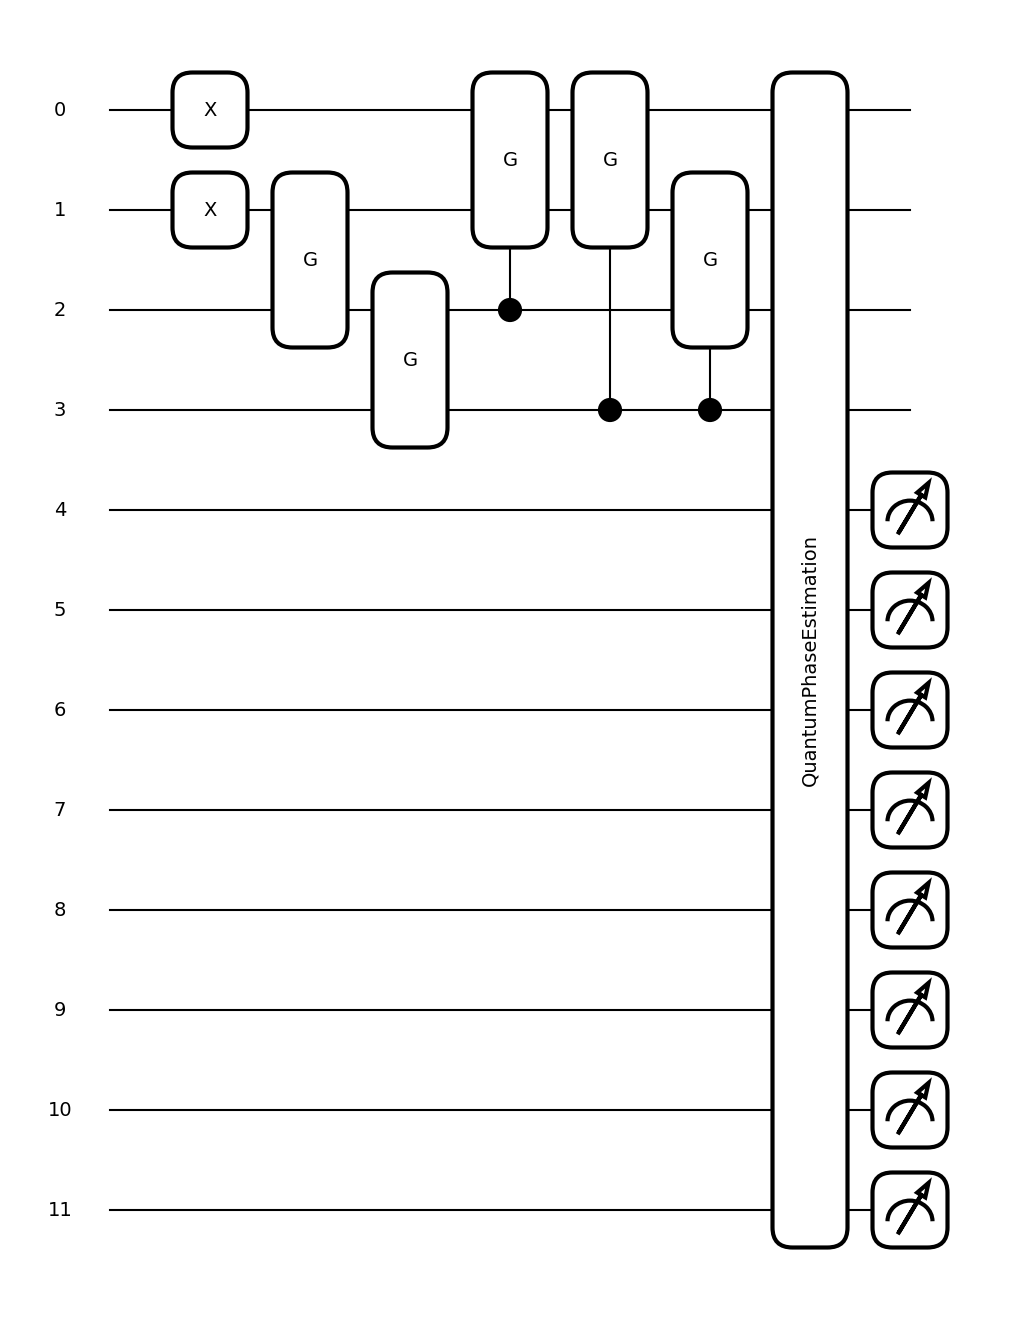

In [235]:
# method_state = "ansatz"; operator = "iHt"
# method_state = "HF" ; operator = "N_0"
# method_state = "HF" ; operator = "N_2"
# method_state = "HF" ; operator = "N_0N_1"

#method_state = "ansatz"; operator = "N_0"
method_state = "ansatz"; operator = "iHt"
#method_state = "HF"; operator = "iHt"
fig, ax  = qml.draw_mpl(circuit_QPE)(H_qubit, method_state, operator)

trotter_step = 25
time_step = 1.e-3
res = circuit_QPE(H_qubit, method_state, operator)
res

In [237]:
ancilla_wires = list(range(Norb, Norb+n_ancilla))
bit_strings = [f"0.{x:0{len(ancilla_wires)}b}" for x in range(len(res))]

idxs = o_np.argsort(res)
wsum = 0.0
for i in range(5):
      idx = idxs[-i-1]
      val = float_from_binary(bit_strings[idx])
      bit_str = bit_strings[idx]
      estimated =idx / 2**n_ancilla
      val2pi = val * 2 * np.pi
      wsum += res[idx] * val2pi
      print(f"{i}th most freq", bit_str, "prob.", res[idx], "value", val, "*2pi", val2pi, "estimated", estimated)
print("wsum", wsum)

0th most freq 0.00000000 prob. 0.9922921217692221 value 0.0 *2pi 0.0 estimated 0.0
1th most freq 0.11111111 prob. 0.00257589628762764 value 0.99609375 *2pi 6.258641614573416 estimated 0.99609375
2th most freq 0.00000001 prob. 0.0021215340794521797 value 0.00390625 *2pi 0.02454369260617026 estimated 0.00390625
3th most freq 0.11111110 prob. 0.0006124660168762856 value 0.9921875 *2pi 6.234097921967246 estimated 0.9921875
4th most freq 0.00000010 prob. 0.000555870904176637 value 0.0078125 *2pi 0.04908738521234052 estimated 0.0078125
wsum 0.020019141353156772


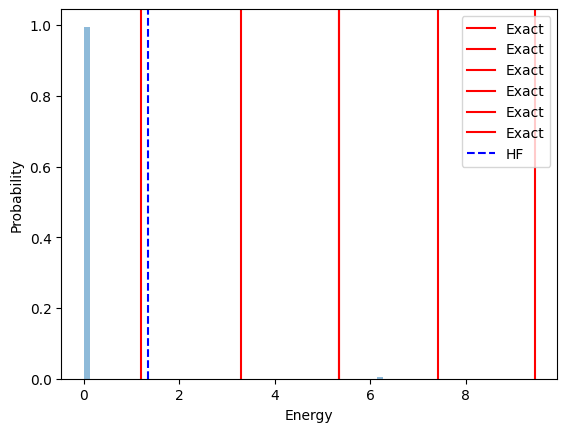

E exact [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758] EHF 1.3399999999999999


In [238]:
data = res #res[1:]

weights = o_np.zeros(len(data))
ys = o_np.zeros(len(data))
for idx in range(len(data)):
    if data[idx] > 1.e-7:
        bitstring = bit_strings[idx]
        lam_t = float_from_binary(bitstring) 
        weights[idx] = data[idx]
        ys[idx] = lam_t * (2* np.pi)
        #print(idx, "weight", data[idx], lam_t * (2* np.pi) )
# draw histogram
fig, ax = plt.subplots()
ax.hist(ys, bins=50, weights=weights, alpha=0.5)
for e in evals:    
    ax.axvline(e, color="red", label="Exact")
ax.axvline(E_HF, color="blue", ls="dashed", label="HF")
ax.set_xlabel("Energy")
ax.set_ylabel("Probability")
ax.legend()
plt.show()
print("E exact", evals, "EHF", E_HF)

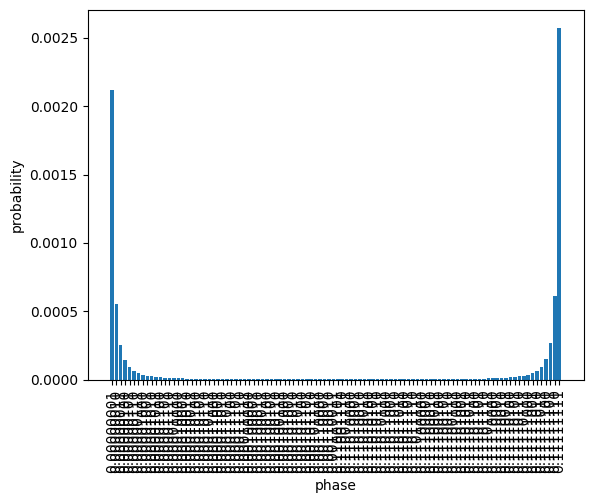

In [239]:
idxs = [ i for i, x in enumerate(res[1:]) if x > 1.e-6]
x = [tmp for i, tmp in enumerate(bit_strings[1:]) if i in idxs]
y = [tmp for i, tmp in enumerate(res[1:]) if i in idxs]
fig = plt.figure()
plt.bar(x,y)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.show()

### Documentを参考に再考...

(`QuantumPhaseEstimation`を使う場合と上の場合とで、同じことはできていそうだ。)


In [13]:
from pennylane.templates import QuantumPhaseEstimation
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit():
    estimation_wires = list(range(Norb, Norb+n_ancilla))

    # State preparation
    qml.PauliX(0)
    qml.PauliX(1)
    if method_state == "ansatz":
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Time Evolution
    U = qml.TrotterProduct(H_qubit, n=trotter_step, time=time_step, order=1)
    
    QuantumPhaseEstimation(
        U,
        estimation_wires=estimation_wires,
    )
    return qml.probs(estimation_wires)

#fig, ax  = qml.draw_mpl(circuit)()
res = circuit()


In [14]:
idx = np.argmax(res)
idx_ = np.argmax(res[1:]) + 1
print("idx", idx, "idx_", idx_)
bitstring = bit_strings[idx_]

lam_t = float_from_binary(bitstring) 
lam_t * (2* np.pi)

idx 0 idx_ 1


0.39269908169872414

In [15]:
estimation_wires = list(range(Norb, Norb+n_ancilla))
results = circuit(estimation_wires)
bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(results))]
idxs = [ i for i, x in enumerate(results) if x > 1.e-6]
x = [tmp for i, tmp in enumerate(bit_strings) if i in idxs]
y = [tmp for i, tmp in enumerate(results) if i in idxs]
fig = plt.figure()
plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.show()

TypeError: circuit() takes 0 positional arguments but 1 was given

In [ ]:
ancilla_wires = list(range(Norb, Norb+n_ancilla))
bit_strings = [f"0.{x:0{len(ancilla_wires)}b}" for x in range(len(res))]

Et = 0.0
for i, bitstring in enumerate(bit_strings):
    prob = res[i]
    fac = float_from_binary(bitstring)
    Et += prob * fac

print("Et", Et , "E", Et * 2 * o_np.pi  /time_step, "Egs_exact ", Egs_exact)

## 正しい結果を得るために...

Trotterとか関係ないoperatorの期待値をQPEで得ることを目指そう。

まずはHadamard testで$N_0 N_1$の期待値を計算する。

In [ ]:
n_ancilla = 1
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_Test():
    q_ancilla = Norb
    # State preparation
    qml.PauliX(0)
    qml.PauliX(1)
    if method_state == "ansatz":
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Define simplified Hamiltonian N_0 N_1 should be probability to occupy 0 and 1 simultaneously
    op0 = qml.Identity(0) - qml.PauliZ(0)
    op1 = qml.Identity(1) - qml.PauliZ(1)
    Hsimple = op0 @ op1 #@ qml.Identity(2) @ qml.Identity(3)
    coeff = 0.25

    # making it to exp(iHt)
    #U = qml.exp(Hsimple, coeff= -1.j * coeff*time_step, num_steps=trotter_step)
    U = qml.exp(Hsimple, coeff= 1.j * coeff*time_step, num_steps=trotter_step)

    # Hadamard test
    qml.Hadamard(wires=q_ancilla)
    qml.ControlledQubitUnitary(U, control_wires=[q_ancilla], wires=range(0, Norb))
    qml.Hadamard(wires=q_ancilla)
    return qml.expval(qml.PauliZ(q_ancilla))

method_state = "HF"
method_state = "ansatz"

trotter_step = 100
time_step = 1.e-3

fig, ax  = qml.draw_mpl(circuit_Test, show_all_wires=True)()
res = circuit_Test().item()
nlog = np.log(res)
p0 = (1 + res) / 2
p1 = (1 - res) / 2
Et = np.arccos(res)
E = Et / time_step
print("initial state", method_state, "res", res, 
     "time_step %3.1e" % time_step, "<N_0N_1> %12.9f" % E )

うまく行った。

続いて、QPEで$N_0 N_1$の期待値を計算してみる。

In [81]:
n_ancilla = 8
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_Test():
    estimation_wires = list(range(Norb, Norb+n_ancilla))

    # State preparation
    qml.PauliX(0)
    qml.PauliX(1)
    if method_state == "ansatz":
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Time Evolution
    # U = qml.TrotterProduct(H_qubit, n=trotter_step, time=time_step, order=1)

    # Define simplified Hamiltonian N_0 N_1 should be probability to occupy 0 and 1 simultaneously
    op0 = qml.Identity(0) - qml.PauliZ(0)
    op1 = qml.Identity(1) - qml.PauliZ(1)
    Hsimple = op0 @ op1 #@ qml.Identity(2) @ qml.Identity(3)
    coeff = 0.25
    U = qml.exp(Hsimple, coeff= 1.j * coeff*time_step, num_steps=trotter_step)

    # QPE part    
    QuantumPhaseEstimation(
        U,
        estimation_wires=estimation_wires,
    )
    return qml.probs(wires=estimation_wires)


In [ ]:
method_state = "ansatz"
trotter_step = 100
time_step = 1.e-3

res = circuit_Test()
print(res)

In [ ]:
idx = np.argmax(res)
idx_ = np.argmax(res[1:]) + 1
print("idx", idx, "idx_", idx_)
bitstring = bit_strings[idx_]

lam_t = float_from_binary(bitstring) 
lam_t * (2* np.pi)

In [ ]:
ancilla_wires = list(range(Norb, Norb+n_ancilla))

bit_strings = [f"0.{x:0{len(ancilla_wires)}b}" for x in range(len(res))]
#bit_strings = [f"0.{len(res)-1-x:0{len(ancilla_wires)}b}" for x in range(len(res))]


Et = 0.0
for i, bitstring in enumerate(bit_strings):
    prob = res[i]
    fac = float_from_binary(bitstring)
    tmp = prob * fac 
    Et += tmp
    if prob > 1.e-6:
        print("Et", tmp , "E", tmp * 2 * o_np.pi  /time_step)
print("Et", Et , "E", Et /time_step ) #"Egs_exact ", Egs_exact)
